In [40]:
import xrft
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from matplotlib import colors, ticker, cm
from xhistogram.xarray import histogram 
import pandas as pd
from matplotlib import colors as cols
from matplotlib.colors import LogNorm

In [41]:
import matplotlib 
font = {'family' : 'sans-serif',
        'size'   : 12}

matplotlib.rc('font', **font)

In [42]:
npick = 24*1 # pick up npick file
dt_out = 90
T1 =  196560 # 3months + 1 day
T2months = 387180 # 6 months

iters = range(T1, T2months, dt_out*npick)
#iters = T2months

data_dir = '/swot/SUM04/dbalwada/channel_beta/01km/tracer_exp2/' 

ds = open_mdsdataset(data_dir, delta_t=40, iters= iters, 
                            prefix=['U','V','W','PTRACER01','tracer1_diag']
                     ,ignore_unknown_vars=True, geometry='cartesian')

In [43]:
horispace = 1e3
time_index = 0
depth = -50
f =  -0.83e-4
X = ds.XC/1e3
Y = ds.YC/1e3
daytime = 86400
boxarea = horispace**2
ybound = 5e5

In [44]:
grid = Grid(ds, periodic='X')

In [45]:
hab01L = xr.open_dataarray('/home/qx344/data/hab01-longtime')
hab05L = xr.open_dataarray('/home/qx344/data/hab05-longtime')
vortold = np.linspace(-7, 7, 240)
strainold = np.linspace(.5e-3, 7, 240)
binbox01old =  (vortold[1]-vortold[0])*(strainold[1]-strainold[0])

In [46]:
vort_1d = grid.interp(grid.interp((grid.diff(ds.V, 'X') - grid.diff(ds.U, 'Y', boundary='extend')),
                   'X'), 'Y', boundary='extend')/horispace

strain_1d = ((grid.diff(ds.U, 'X') - grid.diff(ds.V, 'Y', boundary='extend'))**2 + 
          (grid.interp(grid.interp(grid.diff(ds.V, 'X') + grid.diff(ds.U, 'Y', boundary='extend'),
                       'X'), 'Y', boundary='extend'))**2)**0.5/horispace

In [47]:
vort_1d = vort_1d.sel(YC = slice(ybound,2e6-ybound)).isel(Z=0)
strain_1d = strain_1d.sel(YC = slice(ybound,2e6-ybound)).isel(Z=0)

In [48]:
vort_1d.load();
strain_1d.load();

In [49]:
#### vs jpdf

vortband01 = np.linspace(-7, 7, 70)
strainband01 = np.linspace(.5e-3, 7, 70)

ybound = 5e5

binbox01 =  (vortband01[1]-vortband01[0])*(strainband01[1]-strainband01[0])

vort_1d = (vort_1d/f).rename('vort1_0')
strain_1d = (abs(strain_1d/f)).rename('strain1_0')


hist01 = histogram(vort_1d,strain_1d,dim = ['XC','YC'] , bins=[vortband01,strainband01])
hist01.load();


In [50]:
diffusion = grid.interp(ds.DFrITr01, 'Z', boundary='extend')

In [51]:
kppDif50 = diffusion.sel(Z=-50, method='nearest').sel(YC = slice(ybound,2e6-ybound)) 
kppDif50 = kppDif50.chunk({'XC': 2000, 'YC': 2000, 'time':40})
kppDif50.load()

hab01_Diff50 = histogram(vort_1d,strain_1d, weights = kppDif50, dim = ['XC','YC'] , 
                         bins=[vortband01,strainband01])
hab01_Diff50.load();

In [52]:
surfTracer = ds.PTRACER01
sorfForce = (1-surfTracer).isel(Z=0).sel(YC = slice(ybound,2e6-ybound))/(72*60)

hab01_1SF = histogram(vort_1d,strain_1d, weights = sorfForce, dim = ['XC','YC'] , bins=[vortband01,strainband01])
hab01_1SF.load();

In [53]:
depth = -100
W01_100 = grid.interp(ds.W, 'Z', boundary='extend').sel(Z=depth, method='nearest').sel(YC = slice(ybound,2e6-ybound))
W01_100.load()
W01_100prime = W01_100 - W01_100.mean(dim=['XC','YC'])
Tracer01_100 = ds.PTRACER01.sel(Z=depth,method='nearest').sel(YC = slice(ybound,2e6-ybound))
Tracer01_100.load()
Tracer01_100prime = Tracer01_100 - Tracer01_100.mean(dim=['XC','YC'])


Wtracer01_100 = W01_100*Tracer01_100
Wtracer01_100prime = (Tracer01_100prime*W01_100prime).chunk({'XC': 2000, 'YC': 2000, 'time':40})


hab01_wc100 = histogram(vort_1d,strain_1d, weights = Wtracer01_100, dim = ['XC','YC'] , bins=[vortband01,strainband01])
hab01_wc100.load()

hab01_wc100prime = histogram(vort_1d,strain_1d, weights = Wtracer01_100prime, dim = ['XC','YC'] , bins=[vortband01,strainband01])
hab01_wc100prime.load();

In [54]:
plt.rcParams.update({'font.size': 16})

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:45: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:73: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:101: UserWarning: The following kwargs were not used by contour: 'rasterized'


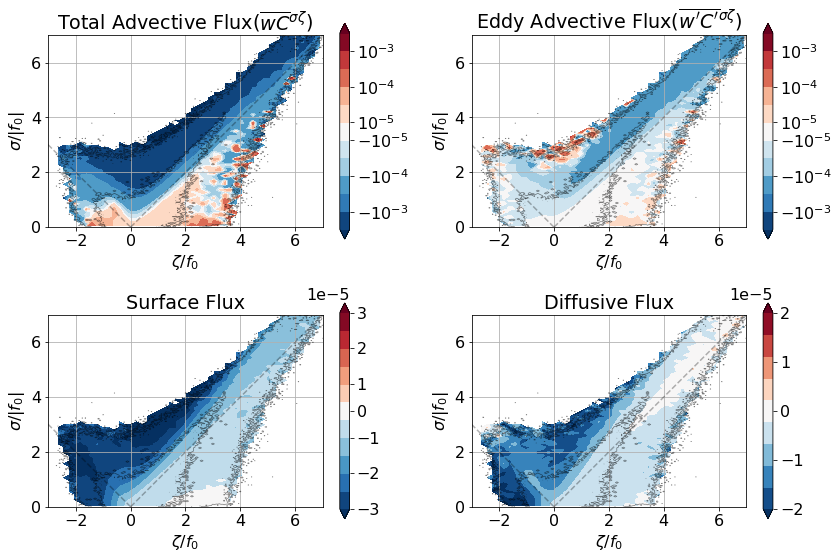

In [56]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

### expected

### surface tracer forcing
hab01LMean = (1**2)/(binbox01old*2000*1000)*hist01.mean(dim='time')
filter01 = xr.where(hab01LMean>5e-5, 1, np.NaN)

# Mean WC
tempWC01100ex = (filter01*hab01_wc100.sum('time')/hist01.sum('time')).T#.mean(dim='time').T
# im12 = ax[0,0].pcolormesh(hist01.vort1_0_bin, hist01.strain1_0_bin, tempWC01100ex, 
#              vmax=5e-3,vmin=-5e-3,norm=cols.SymLogNorm(1e-5), cmap='RdBu_r', rasterized=True)
im00 = ax[0,0].contourf(hist01.vort1_0_bin, hist01.strain1_0_bin, tempWC01100ex, 
             #levels = [ -1e-3,  -5e-4, -1e-4, 0, 1e-4, 5e-4, 1e-3],
                        levels = [-5e-3, -1e-3,  -5e-4, -1e-4, -5e-5, -1e-5, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
                        norm=colors.SymLogNorm(vmin=-5e-3, vmax=5e-3, base=10, linthresh =1e-5, linscale=.1),
                        cmap='RdBu_r',extend='both', rasterized=True)

ax[0,0].set_xlabel('$\zeta/f_0$')
ax[0,0].set_ylabel('$\sigma/|f_0|$')
ax[0,0].set_aspect('equal')
ax[0,0].set_title('Total Advective Flux($\overline{wC}^{\sigma\zeta}$)')
h00 = fig.colorbar(im00, ax=ax[0,0])
h00.set_ticks([-1e-3, -1e-4, -1e-5, 1e-5, 1e-4, 1e-3])
# h01.set_label('kg/(s m$^2$)')
ax[0,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), 
                ((1**2)/(binbox01old*2000*1000)*hab01L.T), alpha=.5, levels=[1e-5],colors ='k', linewidths=0.7)
ax[0,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), 
                ((5**2)/(binbox01old*2000*1000)*hab05L.T), alpha=.5, levels=[1e-5],colors ='k', linewidths=0.7)
ax[0,0].plot(np.linspace(0,-7),np.linspace(0,7),'k--',alpha=.3)
ax[0,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0,0].set_xlim(-3,7)
ax[0,0].set_ylim(0, 7)
ax[0,0].grid()



#Mean W'C'
tempWpCp01100ex = (filter01*hab01_wc100prime.sum(dim='time')/hist01.sum(dim='time') ).T
# im13 = ax[0,1].pcolormesh(hist01.vort1_0_bin, hist01.strain1_0_bin, tempWpCp01100ex, 
#               norm=cols.SymLogNorm(1e-5,vmax=0.5e-3,vmin=-.5e-3,),  cmap='RdBu_r', rasterized=True)
im01 = ax[0,1].contourf(hist01.vort1_0_bin, hist01.strain1_0_bin, tempWpCp01100ex, 
             levels = [-5e-3, -1e-3,  -5e-4, -1e-4, -5e-5, -1e-5, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
                        norm=colors.SymLogNorm(vmin=-5e-3, vmax=5e-3, base=10, linthresh =1e-5, linscale=.1),
                        cmap='RdBu_r',extend='both', rasterized=True)
ax[0,1].set_xlabel('$\zeta/f_0$')
ax[0,1].set_ylabel('$\sigma/|f_0|$')
ax[0,1].set_aspect('equal')
ax[0,1].set_title('Eddy Advective Flux($\overline{w\'C\'}^{\sigma\zeta}$)')
h01 = fig.colorbar(im01, ax=ax[0,1])
h01.set_ticks([-1e-3, -1e-4, -1e-5, 1e-5, 1e-4, 1e-3])
# h13.set_label('kg/(s m$^2$)')
ax[0,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hab01L.T), alpha=.5, 
                levels=[1e-5],colors ='k', linewidths=0.7)
ax[0,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hab05L.T), alpha=.5, 
                levels=[1e-5],colors ='k',  linewidths=0.7)
ax[0,1].plot(np.linspace(0,-7),np.linspace(0,7),'k--',alpha=.3)
ax[0,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0,1].set_xlim(-3,7)
ax[0,1].set_ylim(0, 7)
ax[0,1].grid()




tempsf010ex = (filter01*hab01_1SF/hist01).mean(dim='time').T
# im10 = ax[1,0].pcolormesh(hist01.vort1_0_bin, hist01.strain1_0_bin, -tempsf010ex, 
#              vmax=3e-5,vmin=-3e-5, cmap='RdBu_r', rasterized=True)

im10 = ax[1,0].contourf(hist01.vort1_0_bin, hist01.strain1_0_bin, -tempsf010ex, vmax=3e-5,vmin=-3e-5, 
             levels = [-3e-5, -2.5e-5, -2e-5, -1.5e-5, -1e-5, -0.5e-5, 0.5e-5, 1e-5, 1.5e-5, 2e-5,2.5e-5, 3e-5 ],
              #norm=colors.SymLogNorm(vmin=-5e-5, vmax=5e-5, base=10, linthresh =1e-6, linscale=.1),
             cmap='RdBu_r',extend='both', rasterized=True)

ax[1,0].set_xlabel('$\zeta/f_0$')
ax[1,0].set_ylabel('$\sigma/|f_0|$')
ax[1,0].set_aspect('equal')
ax[1,0].set_title('Surface Flux')
h10 = fig.colorbar(im10, ax=ax[1,0])
h10.set_ticks([-3e-5,  -2e-5, -1e-5, 0, 1e-5,  2e-5, 3e-5 ])
# h01.set_label('kg/(s m$^2$)')
ax[1,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hab01L.T), alpha=.5, 
                levels=[1e-5],colors ='k', linewidths=0.7)
ax[1,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hab05L.T), alpha=.5, 
                levels=[1e-5],colors ='k', linewidths=0.7)
ax[1,0].plot(np.linspace(0,-7),np.linspace(0,7),'k--',alpha=.3)
ax[1,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1,0].set_xlim(-3,7)
ax[1,0].set_ylim(0, 7)
ax[1,0].grid()



tempDif50ex = (filter01*hab01_Diff50/(hist01*1000**2)).mean(dim='time').T

# im11 = ax[1,1].pcolormesh(hist01.vort1_0_bin, hist01.strain1_0_bin, tempDif50ex, 
#              vmax=1.5e-5,vmin=-1.5e-5, cmap='RdBu_r', rasterized=True)
im11 = ax[1,1].contourf(hist01.vort1_0_bin, hist01.strain1_0_bin, tempDif50ex, vmax=2e-5,vmin=-2e-5,
             levels = np.linspace(-2e-5,2e-5,10), #[-3e-5, -2.5e-5, -2e-5, -1.5e-5, -1e-5, -0.5e-5, 0.5e-5, 1e-5, 1.5e-5, 2e-5,2.5e-5, 3e-5 ],
                        #norm=colors.SymLogNorm(vmin=-5e-5, vmax=5e-5, base=10, linthresh =1e-6, linscale=.1),
                        cmap='RdBu_r',extend='both', rasterized=True)

ax[1,1].set_xlabel('$\zeta/f_0$')
ax[1,1].set_ylabel('$\sigma/|f_0|$')
ax[1,1].set_aspect('equal')
ax[1,1].set_title('Diffusive Flux')
h11 = fig.colorbar(im11, ax=ax[1,1])
h11.set_ticks([-2e-5, -1e-5, 0, 1e-5,  2e-5 ])
# h11.set_label('kg/(s m$^2$)')
ax[1,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hab01L.T), alpha=.5, 
                levels=[1e-5],colors ='k', linewidths=0.7)
ax[1,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hab05L.T), alpha=.5, 
                levels=[1e-5],colors ='k', linewidths=0.7)
ax[1,1].plot(np.linspace(0,-7),np.linspace(0,7),'k--',alpha=.3)
ax[1,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1,1].set_xlim(-3,7)
ax[1,1].set_ylim(0, 7)
ax[1,1].grid()





plt.tight_layout()
# plt.savefig('figure9se.pdf')

/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Use the colorbar set_ticks() method instead.
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:39: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:60: UserWarning: The following kwargs were not used by contour: 'rasterized'
/home/qx344/.conda/envs/mitgcm/lib/python3.6/site-packages/ipykernel/__main__.py:83: UserWarning: The following kwargs were not used by contour: 'rasterized'


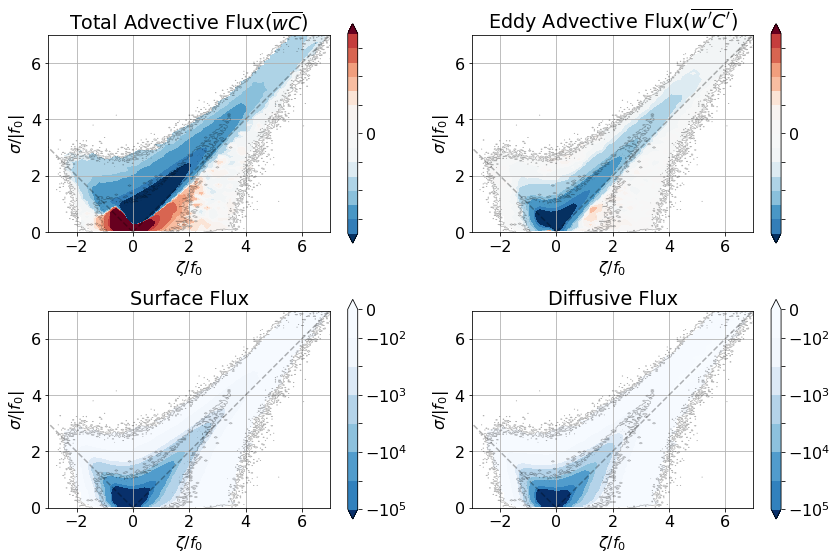

In [57]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

### total sum
hab01LMean = (1**2)/(binbox01*2000*1000)*hist01.mean(dim='time')
filter01 = xr.where(hab01LMean>1e-5, 1, np.NaN)

### surface tracer forcing
tempsf010 = (filter01*hab01_1SF*(1000**2)).mean(dim='time').T
# im00 = ax[1,0].pcolormesh(hist01.vort1_0_bin, hist01.strain1_0_bin, -1*tempsf010, 
#               norm=cols.SymLogNorm(3e2, vmax=1e6,vmin=-1e6), cmap='RdBu_r', 
#                           rasterized=True)
im00 = ax[1,0].contourf(hist01.vort1_0_bin, hist01.strain1_0_bin, -1*tempsf010, 
             levels = [-1e5, -5e4, -1e4, -5e3, -1e3, -5e2, -1e2, 0],
                        norm=colors.SymLogNorm(vmin=-1e6, vmax=0, base=10, linthresh =3e2, linscale=.1),
                        cmap='Blues_r',extend='both', rasterized=True)
ax[1,0].set_xlabel('$\zeta/f_0$')
ax[1,0].set_ylabel('$\sigma/|f_0|$')
ax[1,0].set_aspect('equal')
ax[1,0].set_title('Surface Flux')
h00 = fig.colorbar(im00, ax=ax[1,0])
# h00.set_label('kg/s')
h00.ax.set_yticks([-1e6, -1e5, -1e4, 0])
ax[1,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hab01L.T), levels=[1e-5],colors ='k', linewidths=0.7, alpha=.3)
ax[1,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hab05L.T), levels=[1e-5],colors ='k', linewidths=0.7, alpha=.3)
ax[1,0].plot(np.linspace(0,-7),np.linspace(0,7),'k--',alpha=.3)
ax[1,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1,0].set_xlim(-3,7)
ax[1,0].set_ylim(0, 7)
ax[1,0].grid()


### Diffusion
tempDif50 = (filter01*hab01_Diff50).mean(dim='time').T
# im01 = ax[1,1].pcolormesh(hist01.vort1_0_bin, hist01.strain1_0_bin, tempDif50, 
#              norm=cols.SymLogNorm(3e2, vmax=1e6,vmin=-1e6), cmap='RdBu_r', rasterized=True)
im01 = ax[1,1].contourf(hist01.vort1_0_bin, hist01.strain1_0_bin, tempDif50, 
             levels = [-1e5, -5e4, -1e4, -5e3, -1e3, -5e2, -1e2, 0],
                        norm=colors.SymLogNorm(vmin=-1e6, vmax=0, base=10, linthresh =3e2, linscale=.1),
                        cmap='Blues_r',extend='both', rasterized=True)
ax[1,1].set_xlabel('$\zeta/f_0$')
ax[1,1].set_ylabel('$\sigma/|f_0|$')
ax[1,1].set_aspect('equal')
ax[1,1].set_title('Diffusive Flux')
h01 = fig.colorbar(im01, ax=ax[1,1])
# h01.set_label('kg/s')
ax[1,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hab01L.T), levels=[1e-5],colors ='k', linewidths=0.7, alpha=.3)
ax[1,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hab05L.T), levels=[1e-5],colors ='k', linewidths=0.7, alpha=.3)
ax[1,1].plot(np.linspace(0,-7),np.linspace(0,7),'k--',alpha=.3)
ax[1,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1,1].set_xlim(-3,7)
ax[1,1].set_ylim(0, 7)
ax[1,1].grid()


### WC 
tempWC01100 = (filter01*hab01_wc100*(1000**2)).mean(dim='time').T
im02 = ax[0,0].contourf(hist01.vort1_0_bin, hist01.strain1_0_bin, tempWC01100, 
             levels = [-1e5, -5e4, -1e4, -5e3, -1e3, -5e2, -1e2, 0, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                        norm=colors.SymLogNorm(vmin=-1e6, vmax=1e6, base=10, linthresh =3e2, linscale=.1),
                        cmap='RdBu_r',extend='both', rasterized=True)
ax[0,0].set_xlabel('$\zeta/f_0$')
ax[0,0].set_ylabel('$\sigma/|f_0|$')
ax[0,0].set_aspect('equal')
ax[0,0].set_title('Total Advective Flux($\overline{wC}$)')
h02 = fig.colorbar(im02, ax=ax[0,0])
# h02.set_label('kg/s')
ax[0,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hab01L.T), levels=[1e-5],colors ='k', linewidths=0.7, alpha=.3)
ax[0,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hab05L.T), levels=[1e-5],colors ='k', linewidths=0.7, alpha=.3)
ax[0,0].plot(np.linspace(0,-7),np.linspace(0,7),'k--',alpha=.3)
ax[0,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0,0].set_xlim(-3,7)
ax[0,0].set_ylim(0, 7)
ax[0,0].grid()


### WpCp 
tempWpCp01100 = (filter01*hab01_wc100prime*(1000**2)).mean(dim='time').T
# im03 = ax[0,1].pcolormesh(hist01.vort1_0_bin, hist01.strain1_0_bin, tempWpCp01100, 
#               norm=cols.SymLogNorm(3e2, vmax=1e6,vmin=-1e6), cmap='RdBu_r', rasterized=True)
im03 = ax[0,1].contourf(hist01.vort1_0_bin, hist01.strain1_0_bin, tempWpCp01100, 
             levels = [-1e5, -5e4, -1e4, -5e3, -1e3, -5e2, -1e2, 0, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                        norm=colors.SymLogNorm(vmin=-1e6, vmax=1e6, base=10, linthresh =3e2, linscale=.1),
                        cmap='RdBu_r',extend='both', rasterized=True)
ax[0,1].set_xlabel('$\zeta/f_0$')
ax[0,1].set_ylabel('$\sigma/|f_0|$')
ax[0,1].set_aspect('equal')
ax[0,1].set_title('Eddy Advective Flux($\overline{w\'C\'}$)')
h03 = fig.colorbar(im03, ax=ax[0,1])
# h03.set_label('kg/s')
ax[0,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hab01L.T), levels=[1e-5],colors ='k', linewidths=0.7, alpha=.3)
ax[0,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hab05L.T), levels=[1e-5],colors ='k', linewidths=0.7, alpha=.3)
ax[0,1].plot(np.linspace(0,-7),np.linspace(0,7),'k--',alpha=.3)
ax[0,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0,1].set_xlim(-3,7)
ax[0,1].set_ylim(0, 7)
ax[0,1].grid()

plt.tight_layout()
# plt.savefig('figure10se.pdf')